In [2]:
from skimage import data, segmentation, color
from skimage import graph
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import random

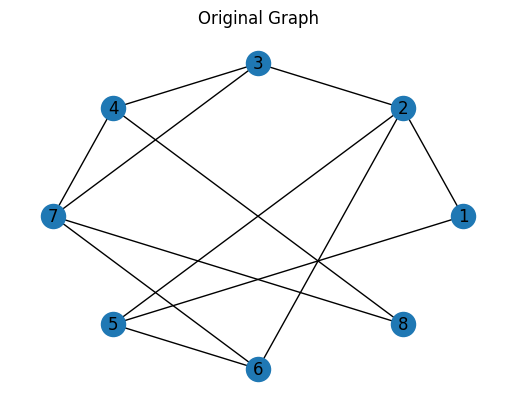

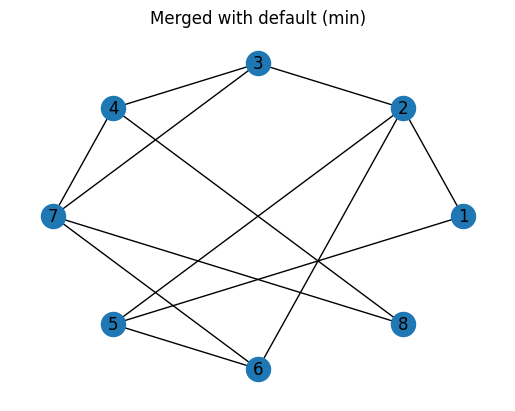

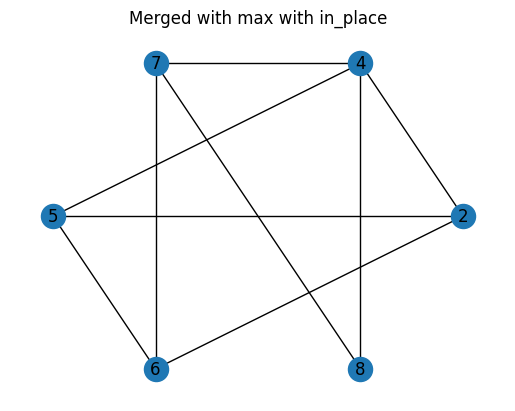

In [3]:
def max_edge(g, src, dst, n):
    """Callback to handle merging nodes by choosing maximum weight.

    Returns a dictionary with `"weight"` set as either the weight between
    (`src`, `n`) or (`dst`, `n`) in `g` or the maximum of the two when
    both exist.

    Parameters
    ----------
    g : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `g` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dict with the "weight" attribute set the weight between
        (`src`, `n`) or (`dst`, `n`) in `g` or the maximum of the two when
        both exist.
    """

    w1 = g[n].get(src, {'weight': -np.inf})['weight']
    w2 = g[n].get(dst, {'weight': -np.inf})['weight']
    if w1 == -np.inf:
        w = w2
    elif w2 == -np.inf:
        w = w1
    else:
        w = w1+w2
    return {'weight': w}


def display(g, title):
    """Displays a graph with the given title."""
    pos = nx.circular_layout(g)
    plt.figure()
    plt.title(title)
    nx.draw(g, pos)
    nx.draw_networkx_labels(g, pos)


g = graph.RAG()
g.add_edge(1, 2, weight=2)
g.add_edge(2, 3, weight=3)
g.add_edge(3, 4, weight=4)
g.add_edge(4, 7, weight=2)
g.add_edge(1, 5, weight=3)
g.add_edge(6, 5, weight=3)
g.add_edge(6, 7, weight=1)
g.add_edge(7, 8, weight=3)
g.add_edge(4, 8, weight=2)
g.add_edge(3, 7, weight=2)
g.add_edge(2, 5, weight=2)
g.add_edge(2, 6, weight=2)

# Assigning dummy labels.
for n in g.nodes():
    g.nodes[n]['labels'] = [n]

gc = g.copy()

display(g, "Original Graph")

display(g, "Merged with default (min)")

gc.merge_nodes(1, 3, weight_func=max_edge)
gc.merge_nodes(3,4, weight_func = max_edge)
display(gc, "Merged with max with in_place")

plt.show()

In [4]:
img = data.coffee()
labels1 = segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
G = graph.rag_mean_color(img, labels1, mode='similarity')

In [5]:
def mincutphase(graph, a):
    rag = graph.copy()
    A = [a]
    while len(rag.nodes())> 2:
        maxweight = np.NINF
        target = np.NINF
        for i in rag.neighbors(A[-1]):
            if (nodewt:= rag[A[-1]][i]['weight'])> maxweight:
                maxweight = nodewt
                target = i
        A.append(target)
        rag.merge_nodes(A[-2],A[-1], weight_func = max_edge)
    cut_of_the_phase = rag[A[-1]][(t:=list(rag.neighbors(A[-1]))[0])]['weight']
    s = A[-1]
    return cut_of_the_phase, s, t

In [6]:
def mincut(graph):
    rag = graph.copy()
    if len(rag.nodes()) == 1:
        return list(rag.nodes())[0], np.inf
    a = random.choice(list(rag.nodes()))
    minimum = np.inf
    supernodes = {}
    while len(rag.nodes())>1:
        cutval, s, t = mincutphase(rag, a)
        if cutval<minimum:
            minimum = cutval
            if t in supernodes.keys():
                T = [t]+supernodes[t]
            else:
                T = [t]
        rag.merge_nodes(s, t, weight_func=max_edge)
        if t not in supernodes.keys():
            supernodes[t] = []
        if s in supernodes.keys():
            nodes = supernodes.pop(s)
            supernodes[t] = nodes + [s] + supernodes[t]
        else:
            supernodes[t].append(s)
    return T, minimum

In [7]:
def _label_all(rag, attr_name):
    """Assign a unique integer to the given attribute in the RAG.
    This function assumes that all labels in `rag` are unique. It
    picks up a random label from them and assigns it to the `attr_name`
    attribute of all the nodes.
    rag : RAG
        The Region Adjacency Graph.
    attr_name : string
        The attribute to which a unique integer is assigned.
    """
    node = min(rag.nodes())
    new_label = rag.nodes[node]['labels'][0]
    for n, d in rag.nodes(data=True):
        d[attr_name] = new_label

In [8]:
def partitionbycut(cut , rag):
    nodes1 = [n for _, n in enumerate(rag.nodes()) if n in cut]
    nodes2 = [n for _, n in enumerate(rag.nodes()) if n not in nodes1]

    sub1 = rag.subgraph(nodes1)
    sub2 = rag.subgraph(nodes2)

    return sub1, sub2

In [9]:
def mincut_relabel(rag, thresh,):
    nodes, leastcut = mincut(rag)
    if leastcut<thresh:
        sub1,sub2 = partitionbycut(nodes, rag)
        mincut_relabel(sub1, thresh)
        mincut_relabel(sub2, thresh)
        return
    _label_all(rag, 'mincut label')


In [10]:
def mincut_segment(labels, rag, thresh):
    mincut_relabel(rag, thresh)
    map_array = np.zeros(labels.max() + 1, dtype=labels.dtype)
    # Mapping from old labels to new
    for n, d in rag.nodes(data=True):
        map_array[d['labels']] = d['mincut label']

    return map_array[labels]

In [11]:
nodes = mincut_segment(labels1, G, 0.01)

In [12]:
len(np.unique(nodes))

30

In [13]:
labels2 = color.label2rgb(nodes, img, kind='avg', bg_label=0)

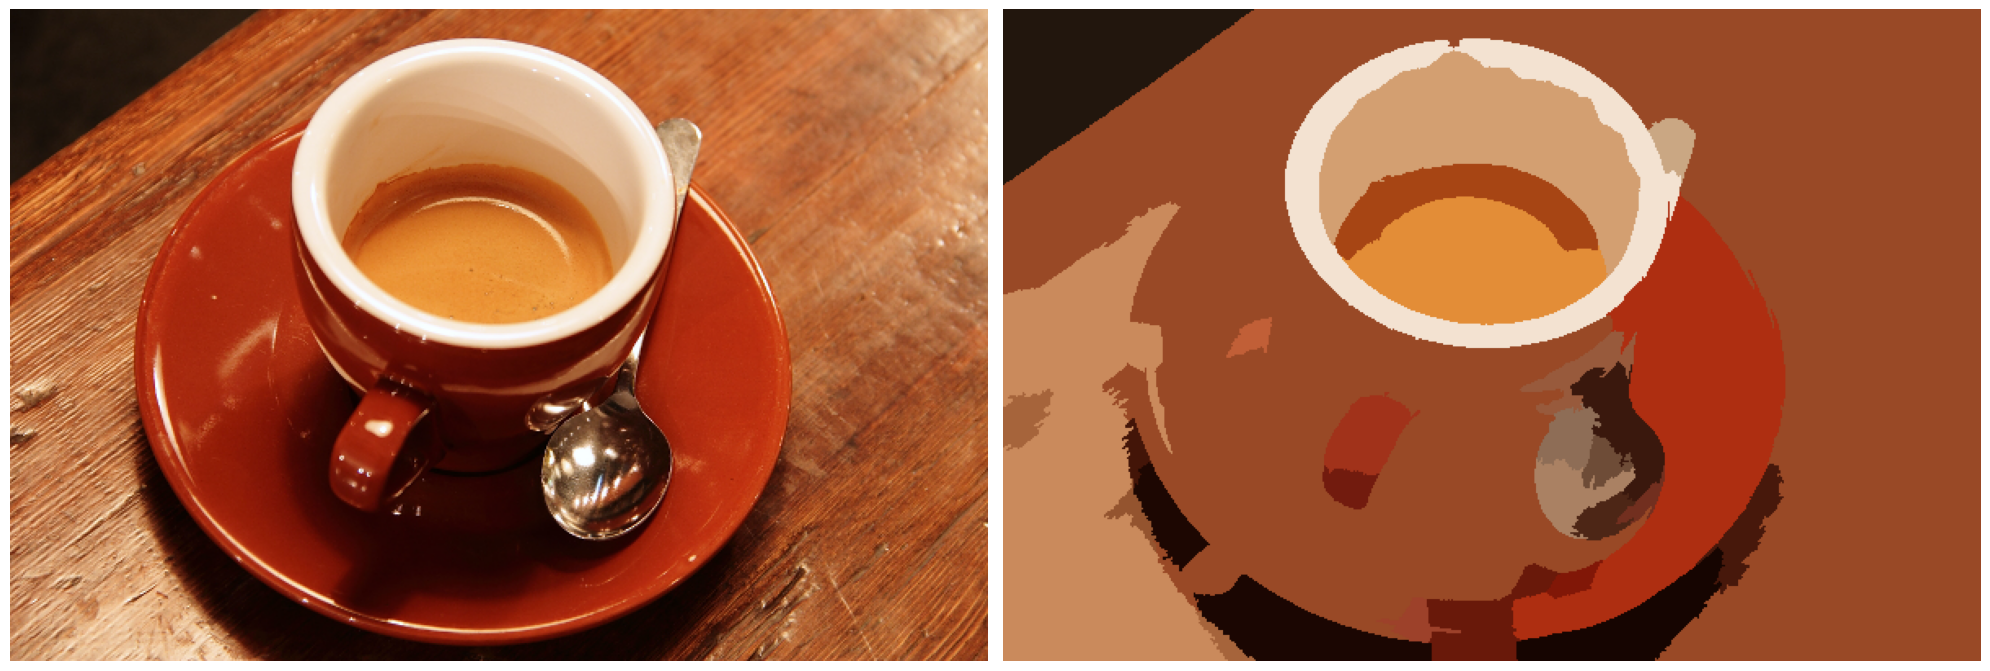

In [14]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20, 8))
ax[0].imshow(img)
ax[1].imshow(labels2)
for a in ax:
    a.axis('off')
plt.tight_layout()